In [139]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [140]:
TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.75 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [141]:
data, all_gdps, all_gts = load_data()

In [ ]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
X_train, y_train, X_valid, y_valid, X_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, mode=MODE, gt_trend_removal=False)

X_high_freq shape : (1715, 96)
X_high_freq head :          date  Expense_average  Research_and_development_average  \
0  2004-01-01              0.0                               0.0   
1  2004-02-01             66.0                               0.0   
2  2004-03-01            100.0                               0.0   
3  2004-04-01              0.0                               0.0   
4  2004-05-01             45.0                               0.0   

   Capital_expenditure_average  Business_average  Cost_average  Tax_average  \
0                          0.0              90.0          27.0         43.0   
1                          0.0             100.0          31.0         62.2   
2                          0.0              91.0          27.0         67.8   
3                          0.0              95.0          30.0         42.0   
4                          0.0              82.0          29.0         35.0   

   Financial_capital_average  Investment_average  \
0             

ValueError: too many values to unpack (expected 4)

## Simple Prediction Model

### We start with a simple regression model

In [143]:
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid

country_train.shape, country_valid.shape, preprocessor.dates_train.shape, preprocessor.dates_valid.shape

((402,), (144,), (402,), (144,))

In [144]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [145]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 100),
            nn.LayerNorm(100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.LayerNorm(20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=1000, learning_rate=1e-3, weight_decay=1e-4):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    
    for t in tqdm(range(num_epochs)):
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)
    loss = loss_fn(y_pred, y_valid_t)
    print(f"Validation loss: {loss.item()}")
    
    return model, training_loss, validation_loss

In [146]:
model, training_loss, validation_loss = train_nn(X_train, y_train, X_valid, y_valid, num_epochs=100, learning_rate=1e-3, weight_decay=1e-2)

  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss: 4.738317966461182


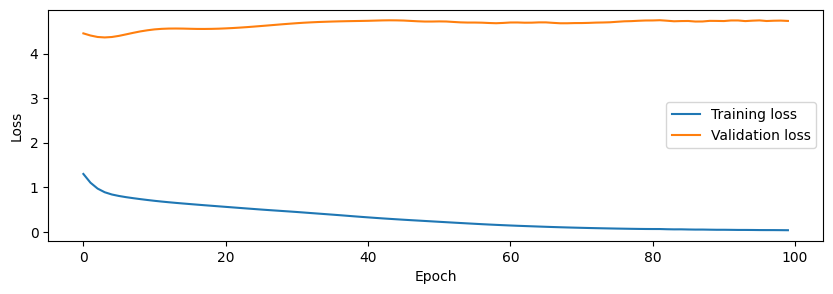

In [147]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [148]:
# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [149]:
preprocessor.dates_valid


0     2019-03-01
1     2019-06-01
2     2019-09-01
3     2019-12-01
4     2020-03-01
         ...    
139   2023-03-01
140   2023-06-01
141   2023-09-01
142   2023-12-01
143   2024-03-01
Name: date, Length: 144, dtype: datetime64[ns]

In [150]:
preprocessor.dates_train.shape, x_train.shape

((402,), torch.Size([402, 104]))

In [151]:
preprocessor.dates_valid.shape, x_valid.shape, y_valid.shape, preprocessor.country_valid.shape, y_pred.shape

((144,), torch.Size([144, 104]), (144,), (144,), (144,))

In [152]:
# Associate the result by country
y_pred_country = pd.DataFrame({'date': preprocessor.dates_valid, 'country': preprocessor.country_valid, 'y_pred': y_pred, 'y_true': y_valid})
y_pred_train_country = pd.DataFrame({'date': preprocessor.dates_train, 'country': preprocessor.country_train, 'y_pred': y_pred_train, 'y_true': y_train})
y_pred_train_country

,date,country,y_pred,y_true
0,2004-12-01,United Kingdom,0.234942,0.261308
1,2018-12-01,Switzerland,0.153135,0.115737
2,2012-06-01,Canada,-0.657231,-0.593124
3,2016-06-01,Korea,0.806354,0.698720
4,2012-06-01,Germany,-0.592919,-0.507645
...,...,...,...,...
397,2006-12-01,Germany,1.914639,1.944422
398,2015-09-01,Germany,-0.799783,-0.769863
399,2016-03-01,Switzerland,-0.013171,-0.023030
400,2005-09-01,United States,0.809619,0.801109


In [153]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [154]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('United Kingdom', 'Switzerland', 'Canada', 'Ko…